# PROYECTO DE FIN DE CURSO: Usando computación evolutiva para encontrar localizaciones optimas de una cadena de supermercados

## CURSO: Optimización Industrial con Computación Evolutiva.
## Integrantes:
1. Amao Suxo, Christian.
2. Piñas Rivera, Jose.
3. Sandoval Huaman, Dennis Edison.



Este proyecto consiste en usar los algoritmos monobjetivo y multiobjetivo aprendidos en el curso para encontrar localizaciones óptimas de una cadena de supermercados. Una conocida cadena de supermercados desea ingresar al mercado limeño. Usted, como experto en IA, ha sido contratado para proponer donde deben ser localizados los supermercados. Para ello, se le está proporcionando un mapa de la ciudad con 60 locales candidatos donde la cadena de supermercados podría localizar sus supermercados. Dicho mapa puede encontrarlo en: https://drive.google.com/open?id=1w7n77ByWK6TrX74lOBTwID719LRj_UQz&usp=sharing
La cadena tiene presupuesto para instalar 10 supermercados. Se le está proporcionando también una tabla con las coordenadas de las localizaciones candidatas y la población estimada que hay en 500 metros a la redonda (Candidatos_supermercados.xlsx).
Su objetivo es escoger los supermercados de manera que se maximice la suma de la población que vive a 500m alrededor de los supermercados y la suma de las distancias entre los supermercados escogidos. Existe la restricción de distancia mínima: cualquier par de supermercados escogidos no pueden estar ubicados a menos de 1Km de distancia en línea recta.

# I.- Planteamiento del algoritmo mono-objetivo

Para el algoritmo mono-objetivo se solicita que:



*   Cada individuo debe representar una selección de 10 localizaciones.
*   Para evaluar un individuo se le pide que diseñe una función fitness que combine la suma de distancias entre todos los posibles pares de localizaciones escogidas en el individuo (45 pares distintos) con la población atendida (suma de población alrededor de cada supermercado escogido).
* La inicialización de los individuos debe considerar crear individuos que representen solo 10 localizaciones elegidas, atendiendo la restricción de distancia mínima. Implemente operadores de cruzamiento, mutación y selección adecuados para garantizar que los individuos resultantes sean válidos (representen elecciones de 10 localizaciones).
* También debe atender la restricción de distancia mínima en los individuos generados en cada generación (puede considerar penalizaciones en el fitness y/o operaciones de reparación de individuos).

Finalmente, con el algoritmo implementado se solicita experimentar varias veces con una población de 100 individuos y 500 generaciones (se sugiere ejecutar 10 veces) y registre en una tabla los mejores individuos de cada ejecución, sus fitness y los componentes del fitness desagregados (suma de distancias y población atendida).




In [1]:
# Procedemos a descargar las librerias necesarias:

import sys
import time
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from random import sample, randrange, shuffle
import pandas as pd
from geopy.distance import geodesic


### Definimos la clase **Location**

Representa una localización candidata. Tiene tres atributos: latitud, longitud y población estimada en 500m.

In [2]:
# Clase para representar una localización candidata
class Location:
    def __init__(self, id, desc, lat, lon, population):
        self.id = id
        self.desc = desc
        self.lat = lat
        self.lon = lon
        self.population = population

### Definimos la estructura de un individuo en el AG con sus operadores genéticos

Antes de definir la estructura del individuo creamos algunas funciones auxiliares que se requerirán para asegurar el cumplimiento de las restricciones que exige el problema:

In [3]:
class Individual:
    def __init__(self, chromosome):
        self.chromosome = chromosome[:]  # Lista de índices de ubicaciones seleccionadas (ej: [3, 5, 12, ...])
        self.fitness = -1  # -1 indica no evaluado

    def crossover_onepoint(self, other):
        """Cruzamiento de un punto que preserva 10 ubicaciones únicas"""
        c = randrange(len(self.chromosome))
        # Combinar y luego eliminar duplicados
        combined = list(set(self.chromosome[:c] + other.chromosome[c:]))
        # Si hay más de 10, muestrear aleatoriamente; si menos, completar
        if len(combined) >= 10:
            new_chrom = sample(combined, 10)
        else:
            new_chrom = combined + sample([x for x in range(len(locations)) if x not in combined], 10 - len(combined))
        return [Individual(new_chrom), Individual(sample(new_chrom, 10))]  # Segundo hijo como permutación

    def crossover_uniform(self, other):
        """Cruzamiento uniforme que preserva 10 ubicaciones únicas"""
        child1 = list(set(self.chromosome + other.chromosome))
        if len(child1) > 10:
            child1 = sample(child1, 10)
        elif len(child1) < 10:
            remaining = [x for x in range(len(locations)) if x not in child1]
            child1 += sample(remaining, 10 - len(child1))
        return [Individual(child1), Individual(sample(child1, 10))]

    def mutation_swap(self):
        """Mutación: reemplaza una ubicación por otra válida"""
        new_chrom = deepcopy(self.chromosome)
        to_remove = random.choice(new_chrom)
        new_chrom.remove(to_remove)

        # Encontrar candidatos que cumplan la distancia mínima
        candidates = [x for x in range(len(locations))
                     if x not in new_chrom and
                     all(geodesic((locations[x].lat, locations[x].lon),
                                      (locations[o].lat, locations[o].lon)).km >= 1
                         for o in new_chrom)]

        if candidates:
            new_chrom.append(random.choice(candidates))
        else:
            # Si no hay candidatos válidos, mantener el original
            new_chrom.append(to_remove)

        return Individual(new_chrom)

    def mutation_multiswap(self):
        """Mutación: reemplaza varias ubicaciones (hasta 50%)"""
        new_chrom = deepcopy(self.chromosome)
        num_to_mutate = random.randint(1, len(new_chrom)//2)

        for _ in range(num_to_mutate):
            if len(new_chrom) == 0:
                break

            to_remove = random.choice(new_chrom)
            new_chrom.remove(to_remove)

            candidates = [x for x in range(len(locations))
                         if x not in new_chrom and
                         all(geodesic((locations[x].lat, locations[x].lon),
                                      (locations[o].lat, locations[o].lon)).km >= 1
                             for o in new_chrom)]

            if candidates:
                new_chrom.append(random.choice(candidates))

        # Asegurar que siempre hay 10
        while len(new_chrom) < 10:
            candidates = [x for x in range(len(locations))
                         if x not in new_chrom and
                         all(geodesic((locations[x].lat, locations[x].lon),
                                      (locations[o].lat, locations[o].lon)).km >= 1
                             for o in new_chrom)]
            if candidates:
                new_chrom.append(random.choice(candidates))
            else:
                break

        return Individual(new_chrom[:10])  # Asegurar máximo 10

### Definimos la función para obtener el fitness de un cromosoma:

In [4]:
def distance_km(loc1, loc2):
    """Calcula distancia geodésica entre dos ubicaciones en km"""
    return geodesic((loc1.lat, loc1.lon), (loc2.lat, loc2.lon)).km

In [5]:
# Función de evaluación (fitness): combina población y distancia y penaliza pares a menos de 1km
def get_fitness(chromosome, locations):
    """
    Calcula el fitness combinando:
    1. Suma de poblaciones en 500m (maximizar)
    2. Suma de distancias entre todos los pares (maximizar)
    Penaliza si hay pares a menos de 1km
    """
    total_pop = sum(locations[i].population for i in chromosome)

    # Calcular suma de distancias entre todos los pares
    total_dist = 0
    min_dist = float('inf')
    for i in range(len(chromosome)):
        for j in range(i+1, len(chromosome)):
            dist = distance_km(locations[chromosome[i]], locations[chromosome[j]])
            total_dist += dist
            if dist < min_dist:
                min_dist = dist

    # Penalización por distancia mínima < 1km
    penalty = 0
    if min_dist < 1:
        penalty = 100000 * (1 - min_dist)  # Penalización proporcional

    # Fitness es combinación de población y distancias (peso 70% población, 30% distancias)
    fitness = 0.7 * total_pop + 0.3 * total_dist - penalty

    return fitness, total_pop, total_dist

### Definimos la función para evaluar la población de individuos

In [6]:
# Evalúa todos los individuos de la población:

def evaluate_population(population, locations):
    for indiv in population:
        if indiv.fitness == -1:
            fitness, pop, dist = get_fitness(indiv.chromosome, locations)
            indiv.fitness = fitness
            indiv.total_pop = pop
            indiv.total_dist = dist

### Definimos una función para inicializar aleatoriamente una población de individuos

In [7]:
# Inicializamos una población de localizaciones válidas:
def init_population(popsize, num_locations, num_selected=10):
    """Inicializa población con individuos válidos (distancias >= 1km)"""
    population = []
    for _ in range(popsize):
        chromosome = []
        candidates = list(range(num_locations))
        shuffle(candidates)

        while len(chromosome) < num_selected and candidates:
            candidate = candidates.pop()
            # Verificar distancia con los ya seleccionados
            valid = True
            for selected in chromosome:
                if distance_km(locations[candidate], locations[selected]) < 1:
                    valid = False
                    break
            if valid:
                chromosome.append(candidate)

        # Si no se completó, completar con los que quedan
        while len(chromosome) < num_selected:
            remaining = [x for x in range(num_locations) if x not in chromosome]
            if remaining:
                chromosome.append(remaining[0])
            else:
                break

        population.append(Individual(chromosome))

    return population

### Definimos los operadores de selección de padres

In [8]:
# Selección por torneo:
def select_parents_tournament(population, tournament_size=3):
    """Selección por torneo"""
    # Primer padre
    tournament = random.sample(population, tournament_size)
    parent1 = max(tournament, key=lambda x: x.fitness)

    # Segundo padre (diferente al primero)
    tournament = [ind for ind in random.sample(population, tournament_size) if ind != parent1]
    if not tournament:  # En caso de que todos sean iguales
        tournament = random.sample(population, tournament_size)
    parent2 = max(tournament, key=lambda x: x.fitness)

    return parent1, parent2

# Selección de sobrevivientes por ranking: Escoge a los mejores n individuos ordenando por fitness (ranking).
def select_survivors_ranking(population, offspring, numsurvivors):
    """Selección por ranking combinando padres e hijos"""
    combined = population + offspring
    combined_sorted = sorted(combined, key=lambda x: x.fitness, reverse=True)
    return combined_sorted[:numsurvivors]

### Algoritmo Genético para encontrar las localizaciones óptimas:

In [9]:
def genetic_algorithm(locations, popsize=100, ngen=500, pmut=0.1,
                     crossover="onepoint", mutation="swap",
                     selection_parents_method="tournament",
                     early_stopping_patience=20, min_delta=0.01):
    """Algoritmo genético para selección de ubicaciones de supermercados

    Args:
        early_stopping_patience: Número de generaciones sin mejora para detener
        min_delta: Cambio mínimo en fitness para considerar como mejora
    """

    # Inicializar población
    population = init_population(popsize, len(locations))
    evaluate_population(population, locations)

    # Historial de fitness
    best_fitness = []
    best_indiv = max(population, key=lambda x: x.fitness)
    best_fitness.append(best_indiv.fitness)
    print(f"Generación 0: Mejor fitness = {best_indiv.fitness}")

    # Variables para early stopping
    no_improvement_count = 0
    previous_best = best_indiv.fitness

    for gen in range(1, ngen+1):
        # Selección de padres y creación de descendencia
        offspring = []
        for _ in range(popsize//2):
            parent1, parent2 = select_parents_tournament(population)

            if crossover == "onepoint":
                children = parent1.crossover_onepoint(parent2)
            elif crossover == "uniform":
                children = parent1.crossover_uniform(parent2)
            else:
                raise ValueError("Operador de cruzamiento no válido")

            # Aplicar mutación
            for child in children:
                if random.random() < pmut:
                    if mutation == "swap":
                        child = child.mutation_swap()
                    elif mutation == "multiswap":
                        child = child.mutation_multiswap()
                    else:
                        raise ValueError("Operador de mutación no válido")
                offspring.append(child)

        # Evaluar descendencia
        evaluate_population(offspring, locations)

        # Selección de supervivientes
        population = select_survivors_ranking(population, offspring, popsize)

        # Actualizar mejor fitness
        current_best = max(population, key=lambda x: x.fitness)
        best_fitness.append(current_best.fitness)

        if current_best.fitness > best_indiv.fitness:
            best_indiv = deepcopy(current_best)

        # Verificar early stopping
        if (current_best.fitness - previous_best) < min_delta:
            no_improvement_count += 1
        else:
            no_improvement_count = 0
            previous_best = current_best.fitness

        if gen % 10 == 0:
            print(f"Generación {gen}: Mejor fitness = {current_best.fitness}")
            print(f"Sin mejora por {no_improvement_count} generaciones")

        # Detener si no hay mejora en 'patience' generaciones
        if no_improvement_count >= early_stopping_patience:
            print(f"\nEarly stopping en generación {gen} - Sin mejora significativa por {early_stopping_patience} generaciones")
            break

    print("\n=== RESULTADOS FINALES ===")
    print(f"Mejor fitness encontrado: {best_indiv.fitness}")
    print(f"Población total atendida: {best_indiv.total_pop}")
    print(f"Suma de distancias: {best_indiv.total_dist:.2f} km")
    print("Ubicaciones seleccionadas:")
    for idx in best_indiv.chromosome:
        loc = locations[idx]
        print(f"  - {loc.desc} (Población: {loc.population}, Coord: {loc.lat}, {loc.lon})")

    return best_indiv, best_fitness

### Probamos simulaciones del algoritmo:

In [12]:
if __name__ == "__main__":
    # Cargar datos de ubicaciones
    data = pd.read_excel("Candidatos_supermercados.xlsx")
    locations = []
    for _, row in data.iterrows():
        locations.append(Location(
            id=row['ID'],
            desc=row['Descripcion'],
            lat=row['Latitud'],
            lon=row['Longitud'],
            population=row['Poblacion500m']
        ))

In [13]:
  # Ejecutar algoritmo genético 10 veces
results = []

for run in range(10):
    print(f"\n=== EJECUCIÓN {run+1} ===")
    best_indiv, fitness_history = genetic_algorithm(
            locations,
            popsize=100,
            ngen=500,
            pmut=0.5,
            crossover="uniform",
            mutation="multiswap",
            selection_parents_method="tournament",
            early_stopping_patience=20,
            min_delta=0.001
        )

    results.append({
            'run': run+1,
            'fitness': best_indiv.fitness,
            'total_pop': best_indiv.total_pop,
            'total_dist': best_indiv.total_dist,
            'locations': best_indiv.chromosome
        })


=== EJECUCIÓN 1 ===
Generación 0: Mejor fitness = 111716.23719309486
Generación 10: Mejor fitness = 117320.5142011189
Sin mejora por 0 generaciones
Generación 20: Mejor fitness = 123382.80651573431
Sin mejora por 0 generaciones
Generación 30: Mejor fitness = 123480.06923984483
Sin mejora por 4 generaciones
Generación 40: Mejor fitness = 123689.55499582691
Sin mejora por 5 generaciones
Generación 50: Mejor fitness = 123898.964330069
Sin mejora por 2 generaciones
Generación 60: Mejor fitness = 123898.964330069
Sin mejora por 12 generaciones

Early stopping en generación 68 - Sin mejora significativa por 20 generaciones

=== RESULTADOS FINALES ===
Mejor fitness encontrado: 123898.964330069
Población total atendida: 176900
Suma de distancias: 229.88 km
Ubicaciones seleccionadas:
  - Av. Oscar R. Benavides, Cercado de Lima 07006 (Población: 16900, Coord: -12.04937, -77.07948)
  - Esquina Chocano-Independencia (Población: 18500, Coord: -12.04253, -77.09595)
  - Jr. Valle Riestra, 609 Pueblo

In [14]:
# Mostramos un resumen de los resultados

results_df = pd.DataFrame(results)

# Guardamos los resultados en Excel
results_df.to_excel("resultados_supermercados_mono_objetivo_v2.xlsx", index=False)

print("\n=== RESUMEN DE 10 EJECUCIONES ===")
print(results_df[['run', 'fitness', 'total_pop', 'total_dist']])



=== RESUMEN DE 10 EJECUCIONES ===
   run        fitness  total_pop  total_dist
0    1  123898.964330     176900  229.881100
1    2  124005.232641     177050  234.108805
2    3  123689.578928     176600  231.929761
3    4  123093.385237     175750  227.950789
4    5  123689.554996     176600  231.849986
5    6  123445.947297     176250  236.490990
6    7  123934.995480     176950  233.318265
7    8  123934.995480     176950  233.318265
8    9  124249.315185     177400  231.050616
9   10  123452.642377     176250  258.807924


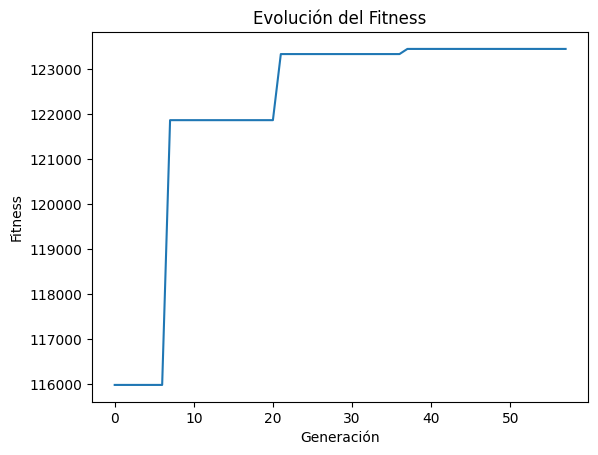

In [15]:
# Graficamos la evolución del fitness (última ejecución)
plt.plot(fitness_history)
plt.title("Evolución del Fitness")
plt.xlabel("Generación")
plt.ylabel("Fitness")
plt.show()